In [1]:
import re
import json
import pandas as pd
import numpy as np
import google.cloud.bigquery as bq
import tensorflow as tf
from tensorflow import keras
from sklearn import model_selection
from sklearn import metrics
from sklearn import impute
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import compose
from sklearn import linear_model
from sklearn import ensemble
from sklearn import feature_extraction
from category_encoders import target_encoder
import matplotlib.pyplot as plt

### Ingest Data

In [2]:
%load_ext google.cloud.bigquery

In [3]:
%%bigquery data
SELECT
  *
FROM `curious-bot.homes.ad_details`
WHERE price_per_sq_m IS NOT NULL
  AND post_code IS NOT NULL

In [4]:
data.set_index('id', inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8864 entries, 0e81059d-2d92-483b-ac73-422e1538400c to 092c74de-da55-42b6-bc0b-ec336ea59b2d
Data columns (total 16 columns):
new_building      8864 non-null bool
promoted          8864 non-null bool
price             8864 non-null int64
area              8864 non-null int64
price_per_sq_m    8864 non-null int64
type              8864 non-null object
viewed            8864 non-null datetime64[ns, UTC]
address           8864 non-null object
post_code         8864 non-null object
street_num        8851 non-null object
street_name       8860 non-null object
postal_town       8864 non-null object
country           8864 non-null object
lat               8864 non-null float64
lng               8864 non-null float64
short_desc        8864 non-null object
dtypes: bool(2), datetime64[ns, UTC](1), float64(2), int64(3), object(8)
memory usage: 1.0+ MB


### Define Utils

In [6]:
def demo(dataset, feature_col):
    example = next(iter(dataset))[0]
    feature_layer = tf.keras.layers.DenseFeatures(feature_col)
    return feature_layer(example).numpy()

def input_to_estimator(X, y, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((dict(X), y))
    return ds.batch(batch_size)

def mean_absolute_prc_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def get_metrics(y_true, y_pred, model_name):
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_prc_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    return {'model': model_name, 'mae': mae, 'mape': mape, 'r2': r2}

### Hyperparameters

In [7]:
random_seed = 42
test_size = 0.3
batch_size = 300
n_area_bins = 5
min_points_per_post_code = 20

### Prepare Train And Test Datasets

In [8]:
X_cols = ['new_building', 'promoted', 'area', 'type', 'post_code']

X = data[X_cols]
y = data.price_per_sq_m

data_train, data_test = model_selection.train_test_split(data,
                                                         test_size=test_size,
                                                         random_state=random_seed)

X_train, X_test = data_train[X_cols], data_test[X_cols]
y_train, y_test = data_train.price_per_sq_m, data_test.price_per_sq_m

ds_train = input_to_estimator(X_train, y_train, batch_size)
ds_test = input_to_estimator(X_test, y_test, batch_size)

### Benchmark Median Price Per Square Meter

In [9]:
metrics_list = []
style_format = {'mae': '{:.0f}', 'mape': '{:.0%}', 'r2': '{:.0%}'}

In [10]:
y_pred = [y_train.median()] * len(y_test)
metrics_list.append(get_metrics(y_test, y_pred, 'benchmark_median_price'))

In [11]:
pd.DataFrame(metrics_list).set_index('model').style.format(style_format)

,mae,mape,r2
model,,,
benchmark_median_price,17599,27%,-0%


### Benchmark Median Price Per Square Meter Per Post Code

In [12]:
med_price_post_code = data_train.groupby('post_code').price_per_sq_m.median()
count_post_code = data_train.groupby('post_code').price_per_sq_m.count()

In [13]:
post_codes_above_min_points = count_post_code[count_post_code > min_points_per_post_code].index

In [14]:
med_price_post_code_sel = med_price_post_code.loc[post_codes_above_min_points]
med_price_post_code_sel.rename('post_code_median_price', inplace=True)

y_pred = data_test.merge(med_price_post_code_sel,
                         how='left',
                         left_on='post_code',
                         right_index=True).post_code_median_price

y_pred.fillna(y_train.median(), inplace=True)

In [15]:
metrics_list.append(get_metrics(y_test, y_pred, 'benchmark_median_price_per_post_code'))

In [16]:
pd.DataFrame(metrics_list).set_index('model').style.format(style_format)

,mae,mape,r2
model,,,
benchmark_median_price,17599,27%,-0%
benchmark_median_price_per_post_code,15229,24%,21%


### Linear Regression

In [17]:
cat_transformer = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='unknown')),
    ('target_enc', target_encoder.TargetEncoder(handle_unknown='ignore'))
])

num_transformer = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='median')),
    ('bucketize', preprocessing.KBinsDiscretizer(n_bins=n_area_bins))
])

preprocessor = compose.ColumnTransformer(transformers=[
    ('cat_transf', cat_transformer, ['post_code']),
    ('num_transf', num_transformer, ['area'])
])

linreg = pipeline.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('linear_reg', linear_model.LinearRegression())
])

In [18]:
linreg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat_transf',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='unknown',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                               

In [19]:
y_pred = linreg.predict(X_test)
metrics_list.append(get_metrics(y_test, y_pred, 'linear_regression'))

In [20]:
pd.DataFrame(metrics_list).set_index('model').style.format(style_format)

,mae,mape,r2
model,,,
benchmark_median_price,17599,27%,-0%
benchmark_median_price_per_post_code,15229,24%,21%
linear_regression,14230,21%,28%


### Gradient Boosting Regressor

In [21]:
boostreg = pipeline.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('linear_reg', ensemble.GradientBoostingRegressor(random_state=random_seed))
])

In [22]:
boostreg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat_transf',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='unknown',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                               

In [23]:
y_pred = boostreg.predict(X_test)
metrics_list.append(get_metrics(y_test, y_pred, 'gradient_boosting_regressor'))

In [24]:
pd.DataFrame(metrics_list).set_index('model').style.format(style_format)

,mae,mape,r2
model,,,
benchmark_median_price,17599,27%,-0%
benchmark_median_price_per_post_code,15229,24%,21%
linear_regression,14230,21%,28%
gradient_boosting_regressor,11306,16%,43%


### Deep Neural Network Regressor

In [25]:
area_bins = list(range(30, 180, 30))
all_post_codes = list(X_train.post_code.unique())

area = tf.feature_column.numeric_column('area')
area_bucket = tf.feature_column.bucketized_column(area, boundaries=area_bins)

promoted = tf.feature_column.numeric_column('promoted')

new_building = tf.feature_column.numeric_column('new_building')

real_est_type = tf.feature_column.categorical_column_with_vocabulary_list('type', ['apartment', 'semi_detached', 'terraced', 'detached'])
real_est_type_1_hot = tf.feature_column.indicator_column(real_est_type)

post_code = tf.feature_column.categorical_column_with_vocabulary_list('post_code', all_post_codes)
post_code_1_hot = tf.feature_column.indicator_column(post_code)
post_code_embedding = tf.feature_column.embedding_column(post_code, dimension=20)
post_code_hash = tf.feature_column.categorical_column_with_hash_bucket('post_code', 50)
post_code_hash_ind = tf.feature_column.indicator_column(post_code_hash)

real_est_type_x_area_bucket = tf.feature_column.crossed_column([real_est_type, area_bucket], hash_bucket_size=20)
real_est_type_x_area_bucket_1_hot = tf.feature_column.indicator_column(real_est_type_x_area_bucket)
real_est_type_x_area_bucket_embedding = tf.feature_column.embedding_column(real_est_type_x_area_bucket, dimension=20)

post_code_embedding_x_area_bucket = tf.feature_column.crossed_column([post_code, area_bucket], hash_bucket_size=200)
post_code_embedding_x_area_bucket_1_hot = tf.feature_column.indicator_column(post_code_embedding_x_area_bucket)
post_code_embedding_x_area_bucket_embedding = tf.feature_column.embedding_column(post_code_embedding_x_area_bucket, dimension=20)

post_code_embedding_x_real_est_type = tf.feature_column.crossed_column([post_code, real_est_type], hash_bucket_size=100)
post_code_embedding_x_real_est_type_1_hot = tf.feature_column.indicator_column(post_code_embedding_x_real_est_type)
post_code_embedding_x_real_est_type_embedding = tf.feature_column.embedding_column(post_code_embedding_x_real_est_type, dimension=20)

wide = [area, promoted, new_building, real_est_type_1_hot, post_code_1_hot]

deep = [area_bucket, post_code_embedding,
        real_est_type_x_area_bucket_embedding,
        post_code_embedding_x_area_bucket_embedding,
        post_code_embedding_x_real_est_type_embedding]

In [26]:
features = [area_bucket, promoted, new_building,
            real_est_type_1_hot, post_code_embedding,
            real_est_type_x_area_bucket_1_hot,
            post_code_embedding_x_area_bucket_1_hot,
            post_code_embedding_x_real_est_type_1_hot]

feature_layer = tf.keras.layers.DenseFeatures(features)

In [27]:
%%time

model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse', 'mae', 'mean_absolute_percentage_error'])

hist = model.fit(ds_train,
                 validation_data=ds_test,
                 epochs=100,
                 verbose=0)

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
CPU times: user 2min 35s, sys: 10.1 s, total: 2min 45s
Wall time: 26.3 s


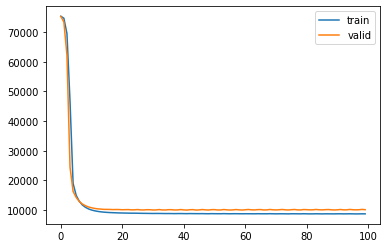

In [28]:
plt.plot(hist.history['mae'], label='train')
plt.plot(hist.history['val_mae'], label='valid')
plt.legend()
plt.show()

In [29]:
y_pred = model.predict(ds_test)

metrics_list.append(get_metrics(y_test, y_pred[:, 0], 'dnn_regressor'))

In [30]:
pd.DataFrame(metrics_list).set_index('model').style.format(style_format)

,mae,mape,r2
model,,,
benchmark_median_price,17599,27%,-0%
benchmark_median_price_per_post_code,15229,24%,21%
linear_regression,14230,21%,28%
gradient_boosting_regressor,11306,16%,43%
dnn_regressor,10047,13%,55%


### Wide And Deep Model

In [31]:
features_input = {'new_building': tf.keras.layers.Input(name='new_building', shape=(), dtype='float32'),
                  'promoted': tf.keras.layers.Input(name='promoted', shape=(), dtype='float32'),
                  'area':  tf.keras.layers.Input(name='area', shape=(), dtype='float32'),
                  'type': tf.keras.layers.Input(name='type', shape=(), dtype='string'),
                  'post_code': tf.keras.layers.Input(name='post_code', shape=(), dtype='string')}

deep_model = tf.keras.layers.DenseFeatures(deep, name='deep_features')(features_input)
deep_model = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(deep_model)
deep_model = tf.keras.layers.Dense(128, activation='relu', name='dense_128')(deep_model)

wide_model = tf.keras.layers.DenseFeatures(wide, name='wide_features')(features_input)

wide_and_deep = tf.keras.layers.concatenate([deep_model, wide_model], name='wide_and_deep_features')
wide_and_deep = tf.keras.layers.Dense(64, activation='relu', name='dense_64')(wide_and_deep)
wide_and_deep = tf.keras.layers.Dense(32, activation='relu', name='dense_32')(wide_and_deep)
wide_and_deep = tf.keras.layers.Dense(16, activation='relu', name='dense_16')(wide_and_deep)

res = tf.keras.layers.Dense(1, activation='relu', name='pred')(wide_and_deep)

model = tf.keras.Model(features_input, res)
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse', 'mae', 'mean_absolute_percentage_error'])

In [33]:
%%time
hist = model.fit(ds_train,
                 validation_data=ds_test,
                 epochs=100,
                 verbose=0)

CPU times: user 53.9 s, sys: 17.7 s, total: 1min 11s
Wall time: 18.6 s


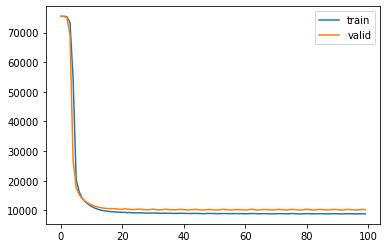

In [34]:
plt.plot(hist.history['mae'], label='train')
plt.plot(hist.history['val_mae'], label='valid')
plt.legend()
plt.show()

In [35]:
y_pred = model.predict(ds_test)

metrics_list.append(get_metrics(y_test, y_pred[:, 0], 'wide_and_deep_regressor'))

In [36]:
pd.DataFrame(metrics_list).set_index('model').style.format(style_format)

,mae,mape,r2
model,,,
benchmark_median_price,17599,27%,-0%
benchmark_median_price_per_post_code,15229,24%,21%
linear_regression,14230,21%,28%
gradient_boosting_regressor,11306,16%,43%
dnn_regressor,10047,13%,55%
wide_and_deep_regressor,10240,13%,53%


### Text Model

In [37]:
stop_words = ['av', 'bak', 'blant', 'etter', 'for', 'fra',
              'gjennom', 'hos', 'i', 'ifølge', 'innen',
              'innenfor', 'med', 'mellom', 'mot', 'om',
              'omkring', 'ovenfor', 'på', 'rundt', 'til',
              'under', 'på grunn av', 'henhold','ved',
              'og', 'over', 'pa', 'etg', 'inkl', 'ingen',
              'kvm', 'en', 'et', 'alt', 'ca', 'm2']

In [38]:
count_vect = feature_extraction.text.CountVectorizer(strip_accents='unicode',
                                                     stop_words=stop_words,
                                                     max_features=400,
                                                     min_df=0.05,
                                                     max_df=0.95
                                                    )

In [39]:
count_vect.fit(data_train.short_desc)

/Users/ruslan.kozhuharov/venvs/tf/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['grunn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.95, max_features=400, min_df=0.05,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['av', 'bak', 'blant', 'etter', 'for', 'fra',
                            'gjennom', 'hos', 'i', 'ifølge', 'innen',
                            'innenfor', 'med', 'mellom', 'mot', 'om', 'omkring',
                            'ovenfor', 'på', 'rundt', 'til', 'under',
                            'på grunn av', 'henhold', 'ved', 'og', 'over', 'pa',
                            'etg', 'inkl', ...],
                strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [40]:
vocab = pd.Series(count_vect.vocabulary_).sort_values().to_frame().transpose().columns.to_list()

In [41]:
print(vocab)

['attraktiv', 'bad', 'balkong', 'barnevennlig', 'beliggenhet', 'felles', 'flott', 'fyring', 'garasje', 'garasjeplass', 'gjennomgaende', 'god', 'grunerløkka', 'hage', 'heis', 'hjørneleilighet', 'høy', 'kjøkken', 'klassisk', 'lave', 'leilighet', 'lekker', 'lys', 'meget', 'moderne', 'peis', 'pen', 'plan', 'planløsning', 'rolig', 'roms', 'romslig', 'selveier', 'sentralt', 'solrik', 'standard', 'stor', 'takhøyde', 'takterrasse', 'terrasse', 'to', 'toppleilighet', 'utsikt', 'varmtvann', 'vestvendt']


In [42]:
vocab_size = len(count_vect.vocabulary_)

In [43]:
text_train = count_vect.transform(data_train.short_desc)
text_test = count_vect.transform(data_test.short_desc)

In [44]:
text_train

<6204x45 sparse matrix of type '<class 'numpy.int64'>'
	with 33250 stored elements in Compressed Sparse Row format>

In [45]:
text_input = tf.keras.layers.Input(shape=(vocab_size, ), dtype='int32', name='short_description')
embedding = tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=32, input_length=vocab_size)(text_input)
dense_text = tf.keras.layers.Dense(16, activation='relu')(embedding)
dense_text = tf.keras.layers.Dense(8, activation='relu')(dense_text)
text_output = tf.keras.layers.Dense(1)(dense_text)

In [46]:
text_model = tf.keras.Model(inputs=text_input, outputs=text_output)
text_model.compile(optimizer='adam', loss='mae', metrics=['mse', 'mae', 'mean_absolute_percentage_error'])

In [47]:
%%time

hist = text_model.fit(text_train.toarray(), y_train,
                      validation_data=(text_test.toarray(), y_test),
                      epochs=200, verbose=0, batch_size=batch_size)

CPU times: user 45.4 s, sys: 9.56 s, total: 55 s
Wall time: 17.6 s


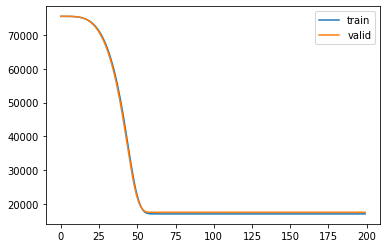

In [48]:
plt.plot(hist.history['mae'], label='train')
plt.plot(hist.history['val_mae'], label='valid')
plt.legend()
plt.show()

In [49]:
y_pred = text_model.predict(text_test.toarray())

metrics_list.append(get_metrics(y_test, y_pred[:, 0, 0], 'nlp_model'))

In [50]:
pd.DataFrame(metrics_list).set_index('model').style.format(style_format)

,mae,mape,r2
model,,,
benchmark_median_price,17599,27%,-0%
benchmark_median_price_per_post_code,15229,24%,21%
linear_regression,14230,21%,28%
gradient_boosting_regressor,11306,16%,43%
dnn_regressor,10047,13%,55%
wide_and_deep_regressor,10240,13%,53%
nlp_model,17594,27%,-0%


### Combine Text And Deep Model

In [117]:
features_input = {'new_building': tf.keras.layers.Input(name='new_building', shape=(), dtype='float32'),
                  'promoted': tf.keras.layers.Input(name='promoted', shape=(), dtype='float32'),
                  'area':  tf.keras.layers.Input(name='area', shape=(), dtype='float32'),
                  'type': tf.keras.layers.Input(name='type', shape=(), dtype='string'),
                  'post_code': tf.keras.layers.Input(name='post_code', shape=(), dtype='string'),
                  'text_vect': tf.keras.layers.Input(name='text_vect', shape=(vocab_size), dtype='float32')}

text_vect = tf.feature_column.numeric_column(key='text_vect', shape=(vocab_size,))

deep_model = tf.keras.layers.DenseFeatures(features + [text_vect], name='deep_features')(features_input)
deep_model = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(deep_model)
deep_model = tf.keras.layers.Dense(128, activation='relu', name='dense_128')(deep_model)
deep_model = tf.keras.layers.Dense(32, activation='relu', name='dense_32')(deep_model)

In [118]:
res = tf.keras.layers.Dense(1, activation='relu', name='pred')(deep_model)

model = tf.keras.Model(features_input, res)
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse', 'mae', 'mean_absolute_percentage_error'])

In [119]:
ds_text_train = tf.data.Dataset.from_tensor_slices(({'area': X_train.area,
                                                     'new_building': X_train.new_building,
                                                     'post_code': X_train.post_code,
                                                     'promoted': X_train.promoted,
                                                     'text_vect': text_train.todense(),
                                                     'type': X_train.type}, y_train))

ds_text_test = tf.data.Dataset.from_tensor_slices(({'area': X_test.area,
                                                    'new_building': X_test.new_building,
                                                    'post_code': X_test.post_code,
                                                    'promoted': X_test.promoted,
                                                    'text_vect': text_test.todense(),
                                                    'type': X_test.type}, y_test))

In [120]:
%%time
hist = model.fit(ds_text_train.batch(batch_size),
                 validation_data=ds_text_test.batch(batch_size),
                 epochs=100,
                 verbose=0)

CPU times: user 58 s, sys: 6.04 s, total: 1min 4s
Wall time: 14.3 s


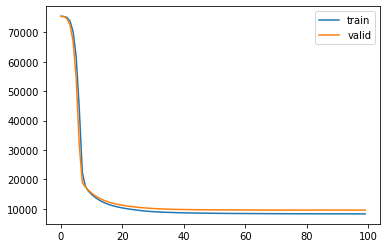

In [121]:
plt.plot(hist.history['mae'], label='train')
plt.plot(hist.history['val_mae'], label='valid')
plt.legend()
plt.show()

In [122]:
y_pred = model.predict(ds_text_test.batch(batch_size))

metrics_list.append(get_metrics(y_test, y_pred[:, 0], 'combined_model'))

In [123]:
pd.DataFrame(metrics_list).set_index('model').style.format(style_format)

,mae,mape,r2
model,,,
benchmark_median_price,17599,27%,-0%
benchmark_median_price_per_post_code,15229,24%,21%
linear_regression,14230,21%,28%
gradient_boosting_regressor,11306,16%,43%
dnn_regressor,10047,13%,55%
wide_and_deep_regressor,10240,13%,53%
nlp_model,17594,27%,-0%
combined_model,9527,13%,59%
